# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', header=0)

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', header=0)

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(f'Number of rows in the dataset:{azdias.shape[0]}')
print(f"Number of columns in the dataset: {azdias.shape[1]}")
azdias.head()

Number of rows in the dataset:891221
Number of columns in the dataset: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Identify missing or unknown data values and convert them to NaNs.
print(f"Total number of original missing data in all the rows and the columns: {azdias.isna().sum().sum()}")

Total number of original missing data in all the rows and the columns: 4896838


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [5]:
feat_info[10:15]

,attribute,information_level,type,missing_or_unknown
10,FINANZTYP,person,categorical,[-1]
11,GEBURTSJAHR,person,numeric,[0]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
14,HEALTH_TYP,person,ordinal,"[-1,0]"


In [6]:
# Some columns don't have missing or unknown values and it's represented in feat_info dataset with empty []
# so this line will remove these columns
feat_info_2 = feat_info.drop(feat_info[feat_info.missing_or_unknown == '[]'].index)

# Now we need to modify the values in missing_or_unknown columns so we can operate on them later
# The code below will replace the things we don't need and the split() will make a list of the values 
# The values in these lists will still be strings but we can change them easily now
feat_info_2['missing_or_unknown'] = feat_info_2.missing_or_unknown.apply(lambda x: list(x[1:-1].replace('[','').replace(']', '').replace(',', ' ').split(' ')))

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
azdias.AGER_TYP.isna().sum()

0

- as it's showing in the last cell AGER_TYP colomn in azdias ds doesn't have any NaN values, and we know form missing_or_unknown column in feat_info that -1 and 0 represent the missing or unknown valus in AGER_TYP, so if we count the number of times 0 and -1 exist in AGER_TYP column and sum them up we would get the expected number of NaN values in this column so we can compare this number with the real number of NaN values after converting and if they both were equal then we have successfully converted the requiered values to NaNs.

In [9]:
exp_NaN_ager_typ = azdias.AGER_TYP.value_counts()[-1] + azdias.AGER_TYP.value_counts()[0]
print(f"We can Expecte AGER_TYP to have : ({exp_NaN_ager_typ}) NaN values after we convert the missing_and_unknown to NaN. ")

We can Expecte AGER_TYP to have : (685843) NaN values after we convert the missing_and_unknown to NaN. 


In [10]:
%%time
# This for loop will convert the missing_or_unknown values to NaN
count = 0
# looping over the 75 column name we have after we removed the onse with no missing_or_unkown values
for column in feat_info_2['attribute']:
    # Looping over the list that represent the missing_or_unknow 
    for value in feat_info_2[feat_info_2['attribute'] == column]['missing_or_unknown'].values[0]:
        # because we have some non numric values (X and XX to be specific) we need to deal with them using if statement
        # here for X
        if value == 'X':
            # comparing the values in the columns with the missing values 
            # if they match they will be conveted to NaN
            azdias[column] = np.where(azdias[column] == value, np.NaN, azdias[column])
        # and here for XX
        elif value == 'XX':
            azdias[column] = np.where(azdias[column] == value, np.NaN, azdias[column])
        # the remaining will be numric and we can convert them to integers befor we compare and then convert to NaNs
        # 
        else:
            azdias[column] = np.where(azdias[column] == int(value), np.NaN, azdias[column])
            
    count += 1
print(f"Looped over {count} columns")

Looped over 75 columns
CPU times: user 1.97 s, sys: 1.94 s, total: 3.92 s
Wall time: 7.72 s


In [11]:
total_NaNs = azdias.isna().sum().sum()
print(f"Now the total number of NaN in azdias df is: {total_NaNs}")
# if the number of NaN in the AGER_TYP match the expeted one print confermation
num_NaN_ag_ty = azdias.AGER_TYP.isna().sum()
if num_NaN_ag_ty == exp_NaN_ager_typ:
    print(f"this confermation will be printed only if both are equal: {num_NaN_ag_ty}")
    print(f"with both of these we can be confidant that the for loop above worked.")

Now the total number of NaN in azdias df is: 8373929
this confermation will be printed only if both are equal: 685843
with both of these we can be confidant that the for loop above worked.


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# making a list to hold the missing values in each column
missing_values_counts = []
# looping over the NaN values in each column
for i in azdias.isna().sum():
    # appending them to the list
    missing_values_counts.append(i)
# missing_values_counts

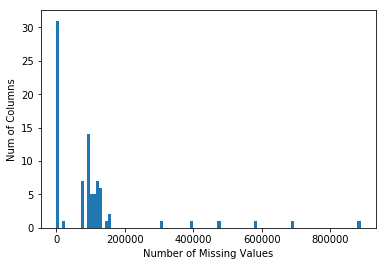

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(x=missing_values_counts, bins=100);
plt.ylabel('Num of Columns')
plt.xlabel('Number of Missing Values')
plt.show()

In [14]:
# gitting the columns name from azdias
columns_names = azdias.columns
# creating a list that will hold the outliers columns by name
outlier_columns = []
for i in columns_names:
    # if a column has more the 200,000 NaN it will be an outlier
    if azdias[i].isna().sum() > 200000:
        outlier_columns.append(i)
# here are the outliers columns
outlier_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
updated_azdias = azdias.drop(outlier_columns, axis=1)
updated_azdias.shape

(891221, 79)

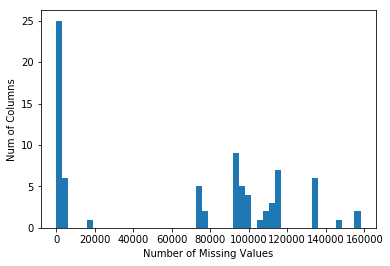

In [17]:
# Investigate patterns in the amount of missing data in each column.
# updated_azdias.isna().sum()
missing_values_counts = []
for i in updated_azdias.isna().sum():
    missing_values_counts.append(i)
plt.hist(x=missing_values_counts, bins=50);
plt.ylabel('Num of Columns')
plt.xlabel('Number of Missing Values')
plt.show()

In [18]:
columns_names = updated_azdias.columns
sixty_k_or_more_null = []
for i in columns_names:
    if updated_azdias[i].isna().sum() > 60000:
        sixty_k_or_more_null.append(i)
len(sixty_k_or_more_null)

47

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)
- so after removing the 6 outliers columns there was still 47 column that have more than 60,000 NaN values.
- These 47 columns came from every type of feature, All of the 9 types have a feature with 60,000 or more NaN valuse.

### There are 6 outlier columns (that have more than 200,000 missing data) below are each one with some details to understand what kind of info we have lost by removing them:
#### 1. Person-level features : 
- AGER_TYP: (Best-ager typology) here is a link that explain what it means [Best-ager](https://www.ambista.com/en/magazine/best-ager#:~:text=Best%20Agers%3A%20an%20affluent%20group%20of%20consumers&text=Basically%20everything%20and%20nothing.,and%20want%20to%20spend%20it.) , total data missing is 685,843
- GEBURTSJAHR: (Year of birth) total data missing is 392,318
- TITEL_KZ: (Academic title like Dr or Pro) total data missing is 889,061

#### 2. Household-level features
- ALTER_HH: (Birthdate of head of household) total data missing is 310,267
- KK_KUNDENTYP: (Consumer pattern over past 12 months) total data missing is 584,612

#### 3. RR3 micro-cell features
- KBA05_BAUMAX: (Most common building type within the microcell) total data missing is 476,524

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

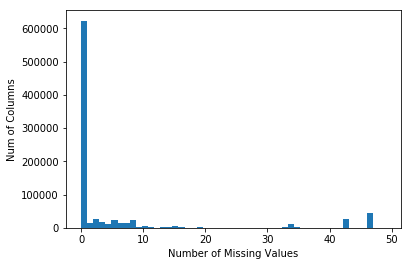

In [19]:
# How much data is missing in each row of the dataset?
num_nan_in_rows = updated_azdias.isnull().sum(axis=1).tolist()

plt.hist(x=num_nan_in_rows, bins=50)
plt.ylabel('Num of Columns')
plt.xlabel('Number of Missing Values')
plt.show();


In [20]:
no_nan_rows = updated_azdias[updated_azdias.isnull().sum(axis=1) <= 0]
rows_with_nans = updated_azdias[updated_azdias.isnull().sum(axis=1) > 0]

((623209, 79), (268012, 79))

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
print(f"There are: {no_nan_rows.shape[0]} rows that have no missing values.")
print(f"There are: {rows_with_nans.shape[0]} rows that have missing values.")

There are: 623209 rows that have no missing values.
There are: 268012 rows that have missing values.


In [22]:
print(f"This is the number of missing values of the no_nan_rows: {no_nan_rows.isna().sum().sum()}")
print(f"This is the number of missing values of the rows_with_nans: {rows_with_nans.isna().sum().sum()}")

This is the number of missing values of the no_nan_rows: 0
This is the number of missing values of the rows_with_nans: 5035304


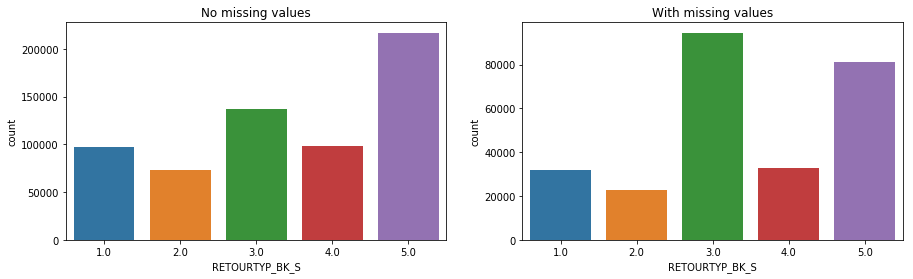

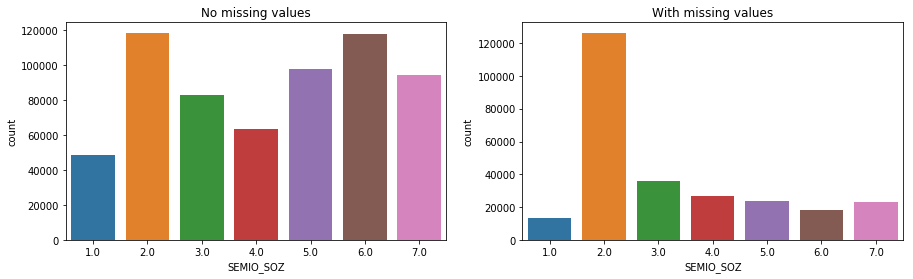

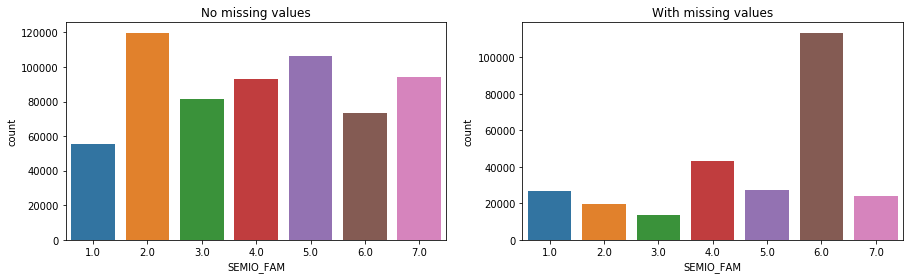

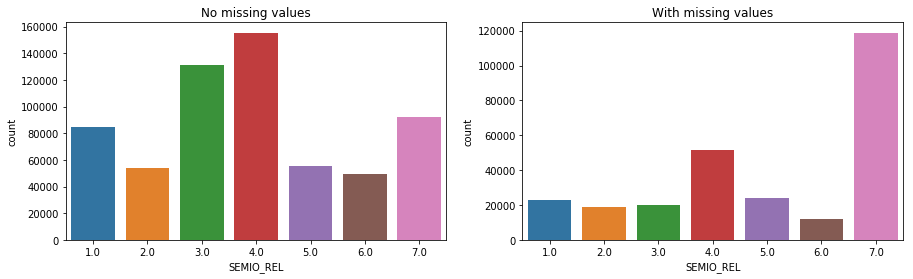

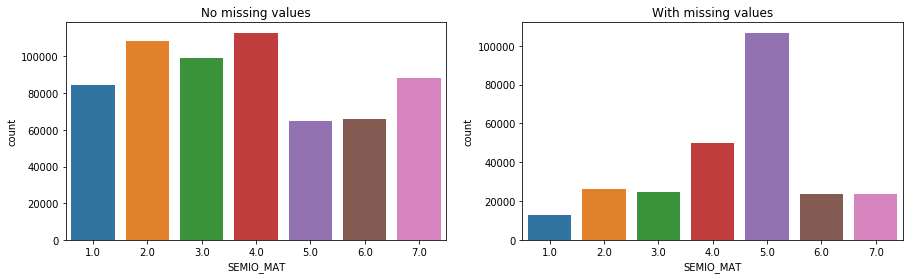

In [168]:
compare_columns = no_nan_rows.columns[10:15]
def create_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('No missing values')
    sns.countplot(azdias.loc[no_nan_rows.index,column],ax=ax1)

    ax2.set_title('With missing values')
    sns.countplot(azdias.loc[rows_with_nans.index,column],ax=ax2)
    
    plt.show()
for i in range(compare_columns.size):
    create_plot(compare_columns[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

**Are the data with lots of missing values are qualitatively different from data with few or no missing values?**
- The answer is yes, and I decided to continue without any missing data, which means we removed around 270,000 rows from the data.
- Now if I set the limit to 3 NaNs per rows and countined with few missing data instead of no missing data the number of rows we will delete will still be above 200,000.
- If i feel like this decision will effect this analysis I would go back and change it.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
feat_info.shape

(85, 4)

In [26]:
# first lets remove the rows that belong to the outlier columns
for name in outlier_columns:
    feat_info.drop(feat_info[feat_info['attribute'] == name].index, inplace = True)
feat_info.shape

(79, 4)

In [27]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [28]:
# creating a list to hold the all of the categorical columns
cat_col = feat_info[feat_info['type'] == 'categorical']['attribute'].values.tolist()

print(f"we have: {len(cat_col)} categoreical columns")

we have: 18 categoreical columns


In [29]:
cat_col

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# creating a list to hold the features names that have more than two values 
multi_lev_cat = [i for i in cat_col if len(no_nan_rows[i].value_counts())>2]
# this list is for binary features valeus 
two_lev_cat = [i for i in cat_col if len(no_nan_rows[i].value_counts())==2]
print(f"Now we have: {len(multi_lev_cat)} Multi_level (Three or more) categorical variable")
print(f"And we have: {len(two_lev_cat)} Two_level (Binary) categorical variable")

Now we have: 13 Multi_level (Three or more) categorical variable
And we have: 5 Two_level (Binary) categorical variable


In [31]:
# Droping the multi level categorical variables
no_nan_rows.drop(multi_lev_cat, inplace=True, axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
print(two_lev_cat)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [33]:
no_nan_rows.shape

(623209, 66)

In [34]:
for column in two_lev_cat:
    # because we need to find the column with non numric values this code will print the columns and the information we need
    print(f"Column Name: {column}\nInfo: {no_nan_rows[column].value_counts().index}\n")

Column Name: ANREDE_KZ
Info: Float64Index([2.0, 1.0], dtype='float64')

Column Name: GREEN_AVANTGARDE
Info: Int64Index([0, 1], dtype='int64')

Column Name: SOHO_KZ
Info: Float64Index([0.0, 1.0], dtype='float64')

Column Name: VERS_TYP
Info: Float64Index([2.0, 1.0], dtype='float64')

Column Name: OST_WEST_KZ
Info: Index(['W', 'O'], dtype='object')



- so only OST_West_KZ column doesn't have numric values so we can replace the W with 0 and O with 1

In [35]:
binary_values = {'W': 0, 'O': 1}
# replace() takes a dict as an argument and replace the values of the df that matches the keyes with the values of the dict
no_nan_rows["OST_WEST_KZ"].replace(binary_values, inplace=True)
# print confermation that OST_WEST_KZ values are now binary 0, 1 and integers
print(f'Column Name: OST_WEST_KZ\nInfo: {no_nan_rows["OST_WEST_KZ"].value_counts().index}\n')

Column Name: OST_WEST_KZ
Info: Int64Index([0, 1], dtype='int64')



/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [36]:
# there is only five categorical variables left
# no_nan_rows.OST_WEST_KZ.value_counts()

In [37]:
multi_lev_cat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Discussion 1.2.1: Re-Encode Categorical Features

**Which ones did I keep, which onse are droped, and what engineering steps are performed?**
- there has been 21 categorical variables in the whole df and we removed 3 of them earlier with the outlier columns
- from the 18 left 13 of them were multi-level (had 3 or more values) so they were removed.
- only 5 variables have been kept for this analysis one of them was not numric OST_WEST_KZ, so we used replace() to replace it's values (W, O) with (0, 1).
- W was for West with 490879 data points and now is zero (0)
- O was for East with 132330 data points and now is one (1)
- the 13 we removed are : CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015
- the 5 we kept are : ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# creating a list to hold all of the  mixed columns
mixed_variables = feat_info[feat_info['type'] == 'mixed']['attribute'].values.tolist()
print(f'There are {len(mixed_variables)} mixed features in the dataset.\nAnd they are :{mixed_variables}')

There are 6 mixed features in the dataset.
And they are :['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [39]:
no_nan_rows.shape

(623209, 66)

In [40]:
# Creating two dictionaries to hold the values that are going to be replaced as the key with the value as replacement.
decade_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
movement_dict = {2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

# Creating two columns that will hold the same values as PRAEGENDE_JUGENDJAHRE have
no_nan_rows['DECADE'] = no_nan_rows['PRAEGENDE_JUGENDJAHRE']
no_nan_rows['MOVEMENT'] = no_nan_rows['PRAEGENDE_JUGENDJAHRE']

# replacing the values in the two columns with the onse in the dictionaries valuse
no_nan_rows["DECADE"].replace(decade_dict, inplace=True)
no_nan_rows["MOVEMENT"].replace(movement_dict, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)

In [41]:
no_nan_rows.shape

(623209, 68)

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# (11:15 replaced by 1), (21:25 replaced by 2), (31:35 replaced by 3), (41:45 replaced by 4), (51:55 replaced by 5)
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1,
               '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3,
               '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5,}

# (11 ,21, 31, 41, 51 replaced by 1), (12, 22, 32, 42, 52 replaced by 2), (13, 23, 33, 43, 53 replaced by 3),
# (14, 24, 34, 54, 55 replaced by 4), (15, 25, 34, 45, 55 replaced by 5)
life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5,
                   '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5,
                   '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5,}

no_nan_rows['WEALTH'] = no_nan_rows['CAMEO_INTL_2015']
no_nan_rows['LIFE_STAGE'] = no_nan_rows['CAMEO_INTL_2015']

no_nan_rows["WEALTH"].replace(wealth_dict, inplace=True)
no_nan_rows["LIFE_STAGE"].replace(life_stage_dict, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [43]:
no_nan_rows.shape

(623209, 70)

In [44]:
droped_mixed_columns = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
no_nan_rows.drop(droped_mixed_columns, inplace=True, axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
no_nan_rows.shape

(623209, 66)

#### Discussion 1.2.2: Engineer Mixed-Type Features

**which columnds did I keep and which are droped? :**
- There are 6 mixed variabels in the df 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE','CAMEO_INTL_2015','PLZ8_BAUMAX
- LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB are removed without replacement.
- PRAEGENDE_JUGENDJAHRE replaced by two columns (DECADE, MOVEMENT)
- CAMEO_INTL_2015 replaced by two columns (WEALTH, LIFE_STAGE).

**what engineering steps are performed?**
- the PRAEGENDE_JUGENDJAHRE had values range from 1:15 and each number represent two things a decade and movement (originaly they represent more but we only kept these two) so we created the DECADE columns with the same values as PRAEGENDE_JUGENDJAHRE then we replaced the values in it with the corresponding decade using the decade dictionary and we did the same with the MOVEMENT column using the movement dictionary. 
- for the CAMEO_INTL_2015 column we did the same as for PRAEGENDE_JUGENDJAHRE column and replaced it with WEALTH, LIFE_STAGE columns using wealth, life_stage dictionaries.

**The four dictionaries we used in this process was created manually using the information in the Data_Dictionary.md file.**

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

df_columns = no_nan_rows.columns.tolist()
ready_columns = 0
for column in df_columns:
    data_type = no_nan_rows[column].dtype
    # This for loop will go through every columns and check if it has any null valus and will also check if the columns 
    # data type is not numric.
    if no_nan_rows[column].isna().sum() > 0 :
        # if true the column name will be printed
        print(f'Column {column} has missing values')
    elif data_type == object or data_type == bool or data_type == 'datetime64':
        # if true the column name will be printed
        print(f'Column {column} has the wrong data type.')
    # if both statement are false the else statement will be triggered and columns that are ready count will be increased.
    else:
        ready_columns += 1
    # finally a confirmation will be printed only if the number of ready columns matches the number of column in our dataset.
    # meaning that all columns have no null values and also all are numric.
    if ready_columns == len(df_columns):
        print('No column has missing values or the wrong data type and all ready to go.')

No column has missing values or the wrong data type and all ready to go.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for column in feat_info_2['attribute']:
        for value in feat_info_2[feat_info_2['attribute'] == column]['missing_or_unknown'].values[0]:
            if value == 'X':
                df[column] = np.where(df[column] == value, np.NaN, df[column])
            elif value == 'XX':
                df[column] = np.where(df[column] == value, np.NaN, df[column])
            else:
                df[column] = np.where(df[column] == int(value), np.NaN, df[column])
            
    # remove selected columns and rows, ...
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(outlier_columns, axis=1)
    # split into two subsets...
    num_nan_in_rows = df.isnull().sum(axis=1).tolist()
    no_NaN_df = pd.DataFrame(columns=df.columns)
    all_NaN_df = pd.DataFrame(columns=df.columns)
    low_indexes = []
    high_indexes = []
    threshold = 0
    for index, value in enumerate(num_nan_in_rows):
        if value == threshold:
            low_indexes.append(index)
        elif value > threshold:
            high_indexes.append(index)
    no_NaN_df = no_NaN_df.append(df.iloc[low_indexes])
    all_NaN_df = all_NaN_df.append(df.iloc[high_indexes])
    
    # select, re-encode, and engineer column values.
    all_cat_col = feat_info[feat_info['type'] == 'categorical']['attribute'].values.tolist()
    
    cat_col = [x for x in all_cat_col if x not in outlier_columns]
    multi_lev_cat = [i for i in cat_col if len(no_NaN_df[i].value_counts())>2]
    two_lev_cat = [i for i in cat_col if len(no_NaN_df[i].value_counts())==2]
    no_NaN_df.drop(multi_lev_cat, inplace=True, axis=1)
    binary_values = {'W': 0, 'O': 1}
    no_NaN_df["OST_WEST_KZ"].replace(binary_values, inplace=True)
    
    all_mixed_variables = feat_info[feat_info['type'] == 'mixed']['attribute'].values.tolist()
    mixed_variables = [x for x in all_mixed_variables if x not in outlier_columns]
    
    decade_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    movement_dict = {2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    no_NaN_df['DECADE'] = no_NaN_df['PRAEGENDE_JUGENDJAHRE']
    no_NaN_df['MOVEMENT'] = no_NaN_df['PRAEGENDE_JUGENDJAHRE']
    no_NaN_df["DECADE"].replace(decade_dict, inplace=True)
    no_NaN_df["MOVEMENT"].replace(movement_dict, inplace=True)
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1,
               '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3,
               '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5,
                       '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5,
                       '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    
    no_NaN_df['WEALTH'] = no_NaN_df['CAMEO_INTL_2015']
    no_NaN_df['LIFE_STAGE'] = no_NaN_df['CAMEO_INTL_2015']
    no_NaN_df["WEALTH"].replace(wealth_dict, inplace=True)
    no_NaN_df["LIFE_STAGE"].replace(life_stage_dict, inplace=True)
    droped_mixed_columns = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
    cleaned_df = no_NaN_df.drop(droped_mixed_columns, axis=1)
    # Return the cleaned dataframe.
    return cleaned_df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print(f'Number of NaN values in the dataset is: {no_nan_rows.isna().sum().sum()}')

Number of NaN values in the dataset is: 0


In [52]:
# Apply feature scaling to the general population demographics data.
from sklearn import preprocessing as p

In [53]:
# creating the scaler form Standard Scaler()
scaler = p.StandardScaler()
# apply transformation and fit the data
df_ss = scaler.fit_transform(no_nan_rows)
scal_azdias = pd.DataFrame(df_ss) #create a dataframe
# setting the columns for the new dataframe to be as the old one.
scal_azdias.columns = no_nan_rows.columns
print(scal_azdias.shape)
scal_azdias.head()

(623209, 66)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.667337,1.441599,0.583438,-0.201181,-0.171845,0.656462,1.164454,0.553670,1.147882,-1.251108
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.667337,0.400949,0.583438,-0.201181,-0.171845,-0.823844,1.164454,-1.806129,-0.909997,0.749822
2,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,0.009742,-0.639702,-0.314764,0.809743,0.263748,1.396614,-0.213400,0.553670,0.461922,0.082845
3,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,-0.667337,1.441599,1.481640,-1.212105,-1.043032,-0.083691,-1.591253,0.553670,1.147882,0.749822
4,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.667337,1.441599,1.481640,0.809743,0.263748,-0.083691,0.475527,0.553670,-0.909997,-0.584131


In [54]:
print(no_nan_rows.shape)
no_nan_rows.head()

(623209, 66)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0,5,4
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,80.0,1.0,2,2


### Discussion 2.1: Apply Feature Scaling

- No missing data in the dataset, and StandardScaler() is used to scale all the features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [56]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scal_azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [57]:
# Investigate the variance accounted for by each principal component.
# this function is from Udacity class room.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

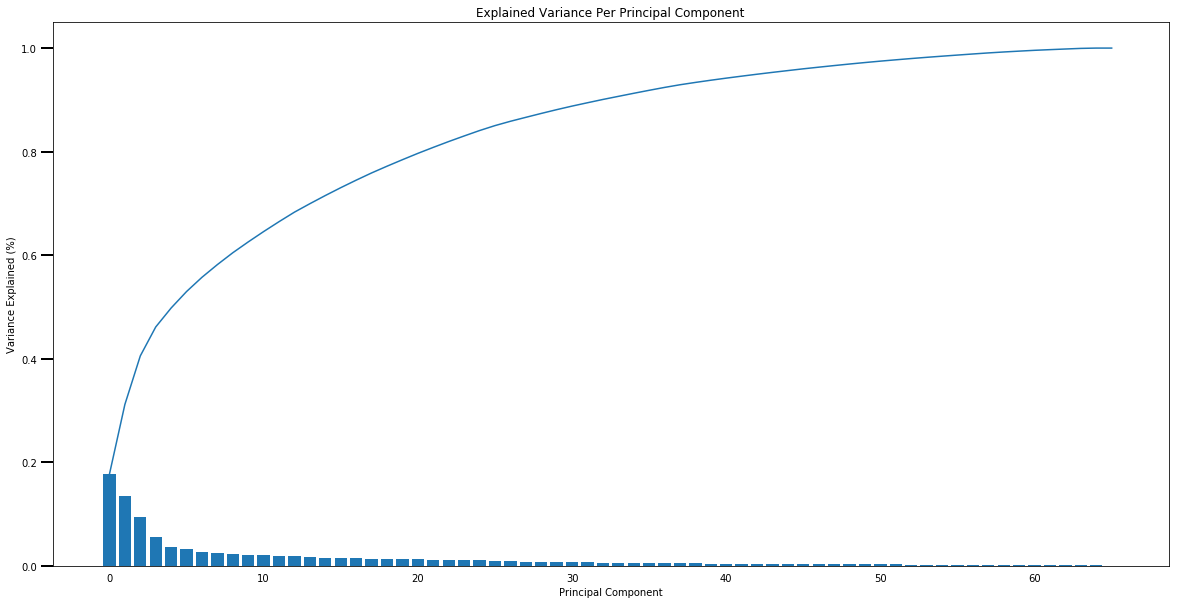

In [58]:
scree_plot(pca)

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_35 = PCA(n_components=35)
pca_azdias = pca_35.fit_transform(scal_azdias)

### Discussion 2.2: Perform Dimensionality Reduction

- first the code for the scree_plot() function is taken form one of the notebooks in Udacity course, it's not my code.
- the pars of the figures represent the amount of variability explained by each component( or eigenvalue ), and the line gives us how much a number of component contribute to the amount of variability explained.
- we can see that 64 component explain around 100% of variability, but we don't have to choose all of the components for example a number of componenet between 30 and 40 can give us between 85 to 90 or more variability explained so we can settle for 35 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
columns = list(scal_azdias.columns)
def weights(col, pca, comp):
    if comp <= len(pca.components_):
        df = pd.DataFrame(pca.components_, columns=col)
        weights = df.iloc[comp].sort_values(ascending=False)
        return weights  
    else:
        print('That is not the right input, please read the docstring before continuing.')
        
#Plot the first component
print(weights(columns, pca_35, 0)[:10])
weights(columns, pca_35, 0)[-11:]

PLZ8_ANTG3            0.220211
PLZ8_ANTG4            0.215096
PLZ8_BAUMAX           0.211935
WEALTH                0.196719
ORTSGR_KLS9           0.192247
HH_EINKOMMEN_SCORE    0.189850
EWDICHTE              0.188612
KBA05_ANTG4           0.148789
FINANZ_HAUSBAUER      0.148400
PLZ8_ANTG2            0.145112
Name: 0, dtype: float64


BALLRAUM               -0.121877
LIFE_STAGE             -0.123100
ALTERSKATEGORIE_GROB   -0.123234
INNENSTADT             -0.160198
KONSUMNAEHE            -0.160814
PLZ8_GBZ               -0.168863
FINANZ_MINIMALIST      -0.208946
KBA05_GBZ              -0.209566
KBA05_ANTG1            -0.218387
PLZ8_ANTG1             -0.221658
MOBI_REGIO             -0.234076
Name: 0, dtype: float64

In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(weights(columns, pca_35, 1)[:10])
weights(columns, pca_35, 3)[-11:]

ALTERSKATEGORIE_GROB    0.258625
SEMIO_ERL               0.230661
FINANZ_VORSORGER        0.226471
SEMIO_LUST              0.179364
RETOURTYP_BK_S          0.164287
SEMIO_KRIT              0.118281
W_KEIT_KIND_HH          0.115873
FINANZ_HAUSBAUER        0.111867
SEMIO_KAEM              0.108145
PLZ8_ANTG3              0.096352
Name: 1, dtype: float64


FINANZ_HAUSBAUER     -0.108006
FINANZ_ANLEGER       -0.116721
KONSUMNAEHE          -0.126321
WEALTH               -0.139420
REGIOTYP             -0.196683
INNENSTADT           -0.200490
BALLRAUM             -0.218663
KKK                  -0.257769
HH_EINKOMMEN_SCORE   -0.264832
WOHNLAGE             -0.280707
MOVEMENT             -0.379189
Name: 3, dtype: float64

In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(weights(columns, pca_35, 2)[:10])
weights(columns, pca_35, 1)[-11:]

SEMIO_VERT              0.349344
SEMIO_SOZ               0.263927
SEMIO_FAM               0.251919
SEMIO_KULT              0.232801
FINANZ_MINIMALIST       0.161735
RETOURTYP_BK_S          0.113107
FINANZ_VORSORGER        0.096425
W_KEIT_KIND_HH          0.090526
ALTERSKATEGORIE_GROB    0.080293
SEMIO_REL               0.078202
Name: 2, dtype: float64


ONLINE_AFFINITAET       -0.157058
SEMIO_RAT               -0.172601
SEMIO_FAM               -0.177592
FINANZ_ANLEGER          -0.204190
SEMIO_KULT              -0.217151
FINANZ_UNAUFFAELLIGER   -0.224634
SEMIO_TRADV             -0.229097
FINANZ_SPARER           -0.233790
SEMIO_PFLICHT           -0.237544
DECADE                  -0.248164
SEMIO_REL               -0.261838
Name: 1, dtype: float64

In [64]:
print(weights(columns, pca_35, 3)[:5])
weights(columns, pca_35, 3)[-6:]

GREEN_AVANTGARDE     0.379189
EWDICHTE             0.248735
ORTSGR_KLS9          0.242894
ONLINE_AFFINITAET    0.136654
SEMIO_DOM            0.122285
Name: 3, dtype: float64


INNENSTADT           -0.200490
BALLRAUM             -0.218663
KKK                  -0.257769
HH_EINKOMMEN_SCORE   -0.264832
WOHNLAGE             -0.280707
MOVEMENT             -0.379189
Name: 3, dtype: float64

### Discussion 2.3: Interpret Principal Components

**reporting my observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?**

### Component (1):

#### positive correlation:
- PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region), PLZ8 macro-cell features
- PLZ8_ANTG4(Number of 10+ family houses in the PLZ8 region), PLZ8 macro-cell features
- PLZ8_BAUMAX(Most common building type within the PLZ8 region), PLZ8 macro-cell features
- WEALTH(example: upper, lower, working class) , micro-cell features
- ORTSGR_KLS9 (Size of community()), Community-level features

#### negative correlation:
- MOBI_REGIO(Movement patterns), RR1 region features
- PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region), PLZ8 macro-cell features
- KBA05_ANTG1(Number of 1-2 family houses in the microcell), RR3 micro-cell features
- KBA05_GBZ (Number of buildings in the microcell), RR3 micro-cell features
- FINANZ_MINIMALIST (Financial typology(low financial interest)), Person-level features

##### First Componenet semes influenced  by micro-cell features, small family houses in RR3 region correlate with one Personal-level feature(low financial interset) and all have a negative correlation with big family houses (+10) in PLZ8 region and also wealth and the size of community.
 .

### Component (2)

#### positive correlation:
- ALTERSKATEGORIE_GROB(Estimated age based on given name analysis), Person-level features
- SEMIO_ERL(Personality typology([event-oriented](https://www.thwink.org/sustain/glossary/EventOrientedThinking.htm#:~:text=Event%20oriented%20thinking%20sees%20the,will%20correspondingly%20change%20the%20event.))), Person-level features
- FINANZ_VORSORGER(Financial typology(be prepared)), Person-level features
- SEMIO_LUST(Personality typology([sensual-minded](https://www.collinsdictionary.com/dictionary/english/sensual#:~:text=1.,was%20a%20very%20sensual%20person.))), Person-level features
- RETOURTYP_BK_S(Return type), Person-level features

#### negative correlation:
- SEMIO_REL(Personality typology(religious)), Person-level features
- DECADE(), Person-level features
- SEMIO_PFLICHT(Personality typology(dutiful)), Person-level features
- FINANZ_SPARER(Financial typology(money-saver)), Person-level features
- SEMIO_TRADV(Personality typology(tradional-minded)) , Person-level features

#### here is a very intersed one as the second componenet is largly influenced by Person-level features, and we can see that Personality typology like religious, dutiful, mony-saver, tradional-minded  all have a negative correlation with Financial typology(be prepared) and Personality typolgy (event-oriented, sensual-minded) and also Age.

### Component (3):

#### positive correlation:
- SEMIO_VERT(Personality typology(dreamful)), Person-level features
- SEMIO_SOZ(Personality typology(socially-minded)), Person-level features
- SEMIO_FAM(Personality typology(family-minded)),Person-level features
- SEMIO_KULT(Personality typology(cultural-minded)),Person-level features
- FINANZ_MINIMALIST(Financial typology(low financial interest)),Person-level features

#### negative correlation:
- ANREDE_KZ(Gender), Person-level features
- SEMIO_KAEM(Personality typology([combative attitude](https://www.dictionary.com/browse/combative#:~:text=Combative%20means%20inclined%20to%20fight,prone%20to%20starting%20physical%20fights.))), Person-level features
- SEMIO_DOM(Personality typology(dominant-minded)), Person-level features
- SEMIO_KRIT(Personality typology(critical-minded)),Person-level features
- SEMIO_RAT(Personality typology(rational)),Person-level features

#### Here is even more interestd one the third Component all 10 (5 pos, 5 neg corr) are Person-level features and 8 of them are Perosnality typology, and you can see some personaliy traits here that gives more room for valid assumptions, -dreamful with socially, family, culturally minded correlate with low financial interest- and all have a negative correlation with -combative attitude and dominant , critical minded, with rational and Gender- .

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [65]:
pca_azdias.shape

(623209, 35)

In [67]:
# Creates a np array from 0 to len pca_azdias and shuffle it to be used as incices
rand_idx = np.random.permutation(pca_azdias.shape[0])
print(rand_idx.shape)
# chossing only 20% of the shuffled incices
size = int(rand_idx.shape[0]*0.20)
sample_idx = rand_idx[-size:]
print(sample_idx.shape)
samp_pca_azdias = pca_azdias[sample_idx,:]
samp_pca_azdias.shape

(623209,)
(124641,)


(124641, 35)

In [68]:
from sklearn.cluster import KMeans
def kmeans_score(data, centers):

    kmeans = KMeans(n_clusters=centers)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [69]:
import time as t

In [70]:
%%time
# Over a number of different cluster counts...
scores = []
k_c = list(range(10, 31))
for k in k_c:
    start_time = t.time()
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    score = kmeans_score(samp_pca_azdias, centers=k)
    scores.append(score)
    # print information every second K
    if k % 2 == 0:
        print(f"Clustering  for:[{k}] Clusteres, SSE is: [{round(score, 4)}], time: [{round(t.time()-start_time, 3)}] s")

Clustering  for:[10] Clusteres, SSE is: [4566718.8754], time: [16.165] s
Clustering  for:[12] Clusteres, SSE is: [4369805.7922], time: [16.585] s
Clustering  for:[14] Clusteres, SSE is: [4261483.2558], time: [22.004] s
Clustering  for:[16] Clusteres, SSE is: [4172539.199], time: [24.715] s
Clustering  for:[18] Clusteres, SSE is: [4067410.7178], time: [33.973] s
Clustering  for:[20] Clusteres, SSE is: [3991623.3072], time: [40.71] s
Clustering  for:[22] Clusteres, SSE is: [3919748.014], time: [33.267] s
Clustering  for:[24] Clusteres, SSE is: [3805030.5721], time: [43.876] s
Clustering  for:[26] Clusteres, SSE is: [3748012.6727], time: [46.049] s
Clustering  for:[28] Clusteres, SSE is: [3700655.6952], time: [52.972] s
Clustering  for:[30] Clusteres, SSE is: [3654532.1617], time: [72.219] s
CPU times: user 12min 23s, sys: 32 s, total: 12min 55s
Wall time: 13min 1s


In [79]:
# scores

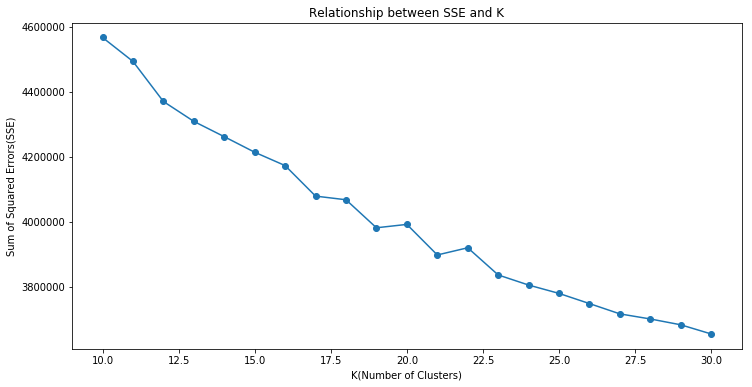

In [71]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(12, 6))
plt.plot(k_c, scores, linestyle='-', marker='o')
plt.xlabel('K(Number of Clusters)')
plt.ylabel('Sum of Squared Errors(SSE)')
plt.title('Relationship between SSE and K');

In [72]:
%%time
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=19)
g_model = kmeans.fit(pca_azdias)
general_pred = g_model.predict(pca_azdias)

CPU times: user 2min 25s, sys: 59.3 s, total: 3min 24s
Wall time: 3min 25s


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [73]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';', header=0)
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [74]:
percent_missing_per_column =(customers.isnull().sum()/len(customers))*100
percent_missing_per_column

AGER_TYP                  0.000000
ALTERSKATEGORIE_GROB      0.000000
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             1.676476
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR               0.000000
GFK_URLAUBERTYP           1.676476
GREEN_AVANTGARDE          0.000000
HEALTH_TYP                0.000000
LP_LEBENSPHASE_FEIN       1.676476
LP_LEBENSPHASE_GROB       1.676476
LP_FAMILIE_FEIN           1.676476
LP_FAMILIE_GROB           1.676476
LP_STATUS_FEIN            1.676476
LP_STATUS_GROB            1.676476
NATIONALITAET_KZ          0.000000
PRAEGENDE_JUGENDJAHRE     0.000000
RETOURTYP_BK_S            1.676476
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [75]:
%%time
customers_clean = clean_data(customers)
print(customers_clean.shape)

(115643, 66)
CPU times: user 1.87 s, sys: 494 ms, total: 2.36 s
Wall time: 2.37 s


In [76]:
print(f'NaN values in customers data :{customers_clean.isna().sum().sum()}')

NaN values in customers data :0


In [77]:
%%time
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# The scaler object was created in section 2.1: apply Feature Scalling (scaler = p.StandardScaler())
scal_customers_clean = scaler.transform(customers_clean)
scal_customers = pd.DataFrame(scal_customers_clean) #create a dataframe
# setting the columns for the new dataframe to be as the old one.
scal_customers.columns = customers_clean.columns
print(scal_customers.shape)
# The pca_35 object was created in section 2.2: Perform Dimensionality Reduction (pca_35 = PCA(n_components=35))
pca_customers = pca_35.transform(scal_customers)
# The g_model was created in section 3.1: Apply Clustering to General Population g_model = kmeans.fit(pca_azdias)
predict_customers = g_model.predict(pca_customers)

(115643, 66)
CPU times: user 549 ms, sys: 203 ms, total: 752 ms
Wall time: 755 ms


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [78]:
general_pred.shape, predict_customers.shape

((623209,), (115643,))

#### Code Explanation for next cell:

- (row 1 and 2) each row or person in general_pred(size of 623209) and predict_customers(size of 115643) is assigned to a specific cluster from our 19 clusters, so what am I going to do in the next cell is to turn both into pandas Series than call value_counts() on them to count every entry for each cluster then calling sort_index() to sort the indecies from 0 to 18.
- (row 3) then I will use pandas concat to create DataFrame from both pandas Series created in last step.
- (row 4) using pandas rename will change the columns names to more appropriate onse.
- (row 5 and 6) creating two new columns (gen_prop, cus_prop) to hold the propabilities for every cluster.
- (row 7) will print confirmation that the sum of each new column will be colse or equal to 100 which means that we didn't loose and values from the clusters.

In [134]:
general_clusters = pd.Series(general_pred).value_counts().sort_index()
customers_clusters = pd.Series(predict_customers).value_counts().sort_index()
gen_cus_ds = pd.concat([general_clusters, customers_clusters], axis=1).reset_index()
gen_cus_ds.rename(columns = {'index': 'Cluster', 0: 'General', 1: 'Customers'}, inplace = True)
gen_cus_ds['General_Proportion'] = ((gen_cus_ds['General'] / gen_cus_ds['General'].sum()) * 100).round(2)
gen_cus_ds['Customer_Proportion'] = ((gen_cus_ds['Customers'] / gen_cus_ds['Customers'].sum()) * 100).round(2)
print(gen_cus_ds['General_Proportion'].sum(), gen_cus_ds['Customer_Proportion'].sum())
gen_cus_ds

100.0 99.98


,Cluster,General,Customers,General_Proportion,Customer_Proportion
0,0,33445,16272,5.37,14.07
1,1,41386,6474,6.64,5.60
2,2,39553,572,6.35,0.49
3,3,23432,3231,3.76,2.79
4,4,43590,1464,6.99,1.27
5,5,48593,833,7.80,0.72
6,6,30091,3734,4.83,3.23
7,7,41876,6897,6.72,5.96
8,8,45497,37394,7.30,32.34
9,9,2415,2346,0.39,2.03


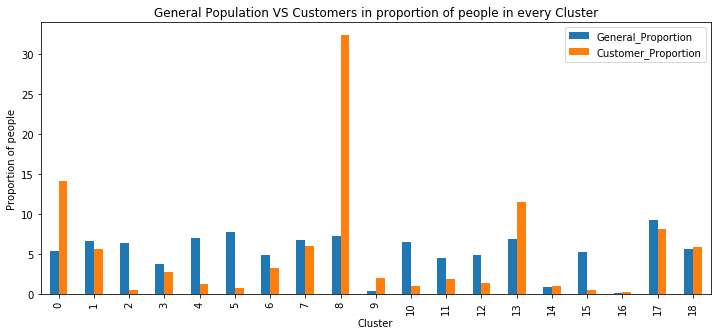

In [135]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
gen_cus_ds.plot(x='Cluster', y=['General_Proportion', 'Customer_Proportion'], kind='bar', figsize=(12, 5))
plt.ylabel('Proportion of people')
plt.title('General Population VS Customers in proportion of people in every Cluster');
plt.show()

- We can see here that the proportion of customers in cluster 8 (32% vs 7%) is much larger(overrepresented) than the general population proportion, which means that the people in cluster 8 are the target audiance for the company.
- the underrepresented clusters are cluster 2 (0.5% vs 6%), cluster 4 (1.3% vs 7%), cluster 5 (7.8% vs 0.7%), cluster 10 (6.5% vs 1%) all of these clusters fit to the 6% or more general vs 2% or less customers which means that the group of persons in these clusters is outside of the target demographics. ( I chose cluster 5 to countinue with this analysis)

In [140]:
general_clusters.shape

(623209,)

In [169]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# starting at 0 the overrepresented clusters in the customers data are cluster 8
cluster_8 = scaler.inverse_transform(pca_35.inverse_transform(g_model.cluster_centers_[8]))
overrepr_cust_8 = pd.Series(data=cluster_8, index=customers_clean.columns)


In [170]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# starting at 0 the underrepresented clusters in the customers data are cluster 5

cluster_5 = scaler.inverse_transform(pca_35.inverse_transform(g_model.cluster_centers_[5]))
underrepr_cust_5 = pd.Series(data = cluster_5, index=customers_clean.columns)

In [171]:
comparison_df = pd.DataFrame()
comparison_df['Features'] = no_nan_rows.columns
comparison_df['Overrepr_8'] = overrepr_cust_8.values.round(decimals=2)
comparison_df['Underrepr_5'] = underrepr_cust_5.values.round(decimals=2)

In [172]:
comparison_df[:25]

,Features,Overrepr_8,Underrepr_5
0,ALTERSKATEGORIE_GROB,3.30,1.76
1,ANREDE_KZ,1.05,0.95
2,FINANZ_MINIMALIST,4.82,1.88
3,FINANZ_SPARER,1.61,4.37
4,FINANZ_VORSORGER,4.22,2.06
5,FINANZ_ANLEGER,1.42,3.53
6,FINANZ_UNAUFFAELLIGER,2.14,3.75
7,FINANZ_HAUSBAUER,1.96,3.63
8,GREEN_AVANTGARDE,0.98,0.13
9,HEALTH_TYP,2.06,2.35


In [173]:
comparison_df[25:50]

,Features,Overrepr_8,Underrepr_5
25,SOHO_KZ,0.00,-0.00
26,VERS_TYP,1.54,1.50
27,ANZ_PERSONEN,2.29,1.51
28,ANZ_TITEL,-0.00,0.00
29,HH_EINKOMMEN_SCORE,2.45,5.54
30,W_KEIT_KIND_HH,4.17,4.47
31,WOHNDAUER_2008,8.51,7.12
32,ANZ_HAUSHALTE_AKTIV,1.78,14.71
33,ANZ_HH_TITEL,0.01,0.05
34,KONSUMNAEHE,3.30,2.03


In [174]:
comparison_df[50:]

,Features,Overrepr_8,Underrepr_5
50,REGIOTYP,3.37,4.98
51,KBA13_ANZAHL_PKW,692.66,499.23
52,PLZ8_ANTG1,2.77,1.37
53,PLZ8_ANTG2,2.62,3.37
54,PLZ8_ANTG3,1.22,2.49
55,PLZ8_ANTG4,0.39,1.33
56,PLZ8_BAUMAX,1.24,3.25
57,PLZ8_HHZ,3.73,3.74
58,PLZ8_GBZ,3.91,2.61
59,ARBEIT,3.08,3.73


### Discussion 3.3: Compare Customer Data to Demographics Data

**reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?**

#### Analysing Cluster 8 (target audience for the company):
**what kinds of people are typified by this cluster? here are 20 of the most notable traits**
- (1) Age: 46 or more, (2) Gender: male, (3) has high financial interest, (4) money-saver, (5) investor.
- (6) high home ownership, (7) return type: low- returner, (8) Religious: more likely to be, (9) Rationality: high, (10) low sexual interests, (10) dutiful.
- (11) tradional-minded, (12) high or very high houshold income, (13) more likely to be in the west, (14) more likely to be in good neighborhood, (15) high purchasing power in the region they live in.
- (16) low movement, (17) lives in upper middel class, (18) decade: 60s, (19) Wealth: prosperous households, (20) Life Stage: older families and mature couples.

#### Analysing Cluster 5 (outside of the target demographics):
**what kinds of people are typified by this cluster? here are 20 of the most notable traits**
- (1) Age: younger than 45, (2) Gender: male, (3) low financial interest, (4) not a money-saver, (5) low or average invesment.
- (6) average or low home ownership, (7) return type: more likely to be heavy returner, (8) Religious: less likely to be, (9) Rationality: average, (10) high sexual interests, (10) not dutiful. 
- (11) not tradional-minded, (12) low or average houshold income, (13) more likely to be in the west, (14) more likely to be in average or poor neighborhood, (15) average purchasing power in the region they live in. 
- (16) high movement, (17) lives in lower middel class, (18) decade: 80s or 90s, (19) Wealth: Less Affluent Households, (20) Life Stage: Young Couples With Children.

**It's important to note that I didn't include any missing data for this analysis, which means that a big chunk of the data have been left out, the result might have been different if I included them, or if the number of missing data was not as large to begin with.**

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.